<a href="https://colab.research.google.com/github/oli2v/partoo-assignment/blob/staging/notebooks/Partoo_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import libraries and set environment variables

In [ ]:
import os
import json
import numpy as np
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "dbt-user-creds.json"

In [ ]:
client = bigquery.Client()

#2. Load datasets

## 2.1. Business

In [ ]:
business_pdf = pd.read_gbq(
    "select * from partoo-assignment.operations_staging.dim_business",
    project_id="partoo-assignment",
    dialect="standard"
)
business_pdf

,business_id,status,invoice_date,invoiced_amount,payment_date,paid_amount,paid_ratio,discrepancy,payment_time,months_before_churn
0,6315de66901cd417fda0d8ac,Active,2024-02-29,23376.44,NaT,NaN,NaN,NaN,<NA>,<NA>
1,635be8b5d980530073a5855a,Active,2023-10-04,20113.53,NaT,NaN,NaN,NaN,<NA>,<NA>
2,6540fed36bb66f440ee056fe,Active,2023-12-29,23625.34,NaT,NaN,NaN,NaN,<NA>,<NA>
3,6038d77d5911bde304145820,Active,2023-11-04,23889.71,NaT,NaN,NaN,NaN,<NA>,<NA>
4,616453d53f4e1b0c23605ef4,Active,2024-02-25,21035.32,NaT,NaN,NaN,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...
4304,63906dbf5860eab399e9d9dd,Inactive,2023-09-27,20699.84,2023-10-04,17137.18,0.83,3562.66,7,11
4305,637df973a12780615a372b62,Inactive,2023-11-11,19401.19,2023-11-18,14864.58,0.77,4536.61,7,11
4306,620e8286f5153df161623ab1,Inactive,2023-11-25,23650.00,2023-12-02,12811.16,0.54,10838.84,7,11
4307,6331a377223b9b8619c05baa,Inactive,2023-12-01,22472.44,2023-12-08,14046.21,0.63,8426.23,7,11


##2.2 Billing

In [ ]:
billing_pdf = pd.read_gbq(
    "select * from partoo-assignment.operations_staging.fct_billing",
    project_id="partoo-assignment",
    dialect="standard"
)
billing_pdf["date"] = pd.to_datetime(billing_pdf["date"])

##2.3. Subscription

In [ ]:
subscription_pdf = pd.read_gbq(
    "select * from partoo-assignment.operations_staging.fct_subscription",
    project_id="partoo-assignment",
    dialect="standard"
)
subscription_pdf.sort_values(by="date", ascending=True, inplace=True)

## 2.4. Conversation

In [ ]:
conversation_pdf = pd.read_gbq(
    "select * from partoo-assignment.operations.conversation",
    project_id="partoo-assignment",
    dialect="standard"
)

In [ ]:
def get_contact_id(row):
  contact_dict = json.loads(row["contacts"])
  contact_list = contact_dict["contacts"]
  return contact_list

def get_statistics(row):
    statistics_dict = json.loads(row["statistics"])
    return statistics_dict

def get_tags(row):
  tag_list = json.loads(row["tags"])["tags"]
  return tag_list

def get_topics(row):
  try:
    topic_list = json.loads(row["topics"])["topics"]
  except TypeError:
    return []
  return topic_list

In [ ]:
conversation_pdf["contact_list"] = conversation_pdf.apply(get_contact_id, axis=1)
conversation_pdf["statistics_dict"] = conversation_pdf.apply(get_statistics, axis=1)
conversation_pdf["tag_list"] = conversation_pdf.apply(get_tags, axis=1)
conversation_pdf["topic_list"] = conversation_pdf.apply(get_topics, axis=1)

In [ ]:
exploded_pdf = conversation_pdf.explode("contact_list").explode("topic_list").explode("tag_list")
exploded_pdf

,id,open,read,tags,type,state,topics,assignee,contacts,priority,...,team_assignee_id,admin_assignee_id,custom_attributes,conversation_rating,title,first_contact_reply,contact_list,statistics_dict,tag_list,topic_list
0,14606342183,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[],""total_count"":0,""type"":""topic.list""}",None,"{""contacts"":[{""id"":""59e9c09d2fa8a2e446f8c8cc"",...",not_priority,...,<NA>,<NA>,{},None,None,1518512540,"{'id': '59e9c09d2fa8a2e446f8c8cc', 'type': 'co...","{'count_assignments': 0, 'count_conversation_p...",NaN,NaN
1,15306592060,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[{""id"":59902,""name"":""PARTOO"",""type"":...",None,"{""contacts"":[{""id"":""5aabd841bca508aac7ea611a"",...",not_priority,...,<NA>,<NA>,{},None,None,1521645500,"{'id': '5aabd841bca508aac7ea611a', 'type': 'co...","{'count_assignments': 0, 'count_conversation_p...",NaN,"{'id': 59902, 'name': 'PARTOO', 'type': 'topic'}"
1,15306592060,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[{""id"":59902,""name"":""PARTOO"",""type"":...",None,"{""contacts"":[{""id"":""5aabd841bca508aac7ea611a"",...",not_priority,...,<NA>,<NA>,{},None,None,1521645500,"{'id': '5aabd841bca508aac7ea611a', 'type': 'co...","{'count_assignments': 0, 'count_conversation_p...",NaN,"{'id': 62578, 'name': 'RM', 'type': 'topic'}"
2,16470739497,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[],""total_count"":0,""type"":""topic.list""}",None,"{""contacts"":[{""id"":""5b02eb4af6741763e74dbf11"",...",not_priority,...,<NA>,<NA>,{},None,None,1526918909,"{'id': '5b02eb4af6741763e74dbf11', 'type': 'co...","{'count_assignments': 2, 'count_conversation_p...",NaN,NaN
3,16558236246,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[],""total_count"":0,""type"":""topic.list""}",None,"{""contacts"":[{""id"":""59e48fd9bcffade9978913ee"",...",not_priority,...,<NA>,<NA>,{},None,None,1527169182,"{'id': '59e48fd9bcffade9978913ee', 'type': 'co...","{'count_assignments': 0, 'count_conversation_p...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131605,77900500788009,True,False,"{""tags"":[{""applied_at"":1707489171,""applied_by""...",conversation,open,"{""topics"":[{""id"":59905,""name"":""PUBLISHERS"",""ty...",None,"{""contacts"":[{""id"":""62a040f5da9272c512fe857e"",...",not_priority,...,7123736,7068660,"{""Language"":""Italian""}",None,b'm\xa7\xb8\x7f\xb6\xf9w\x8e\xbbwV\xfckw\xf6\x...,1707489163,"{'id': '62a040f5da9272c512fe857e', 'type': 'co...","{'count_assignments': 1, 'count_conversation_p...","{'applied_at': 1707489172, 'applied_by': {'id'...","{'id': 59905, 'name': 'PUBLISHERS', 'type': 't..."
131605,77900500788009,True,False,"{""tags"":[{""applied_at"":1707489171,""applied_by""...",conversation,open,"{""topics"":[{""id"":59905,""name"":""PUBLISHERS"",""ty...",None,"{""contacts"":[{""id"":""62a040f5da9272c512fe857e"",...",not_priority,...,7123736,7068660,"{""Language"":""Italian""}",None,b'm\xa7\xb8\x7f\xb6\xf9w\x8e\xbbwV\xfckw\xf6\x...,1707489163,"{'id': '65b0eef0144c2c94217386f6', 'type': 'co...","{'count_assignments': 1, 'count_conversation_p...","{'applied_at': 1707489171, 'applied_by': {'id'...","{'id': 59905, 'name': 'PUBLISHERS', 'type': 't..."
131605,77900500788009,True,False,"{""tags"":[{""applied_at"":1707489171,""applied_by""...",conversation,open,"{""topics"":[{""id"":59905,""name"":""PUBLISHERS"",""ty...",None,"{""contacts"":[{""id"":""62a040f5da9272c512fe857e"",...",not_priority,...,7123736,7068660,"{""Language"":""Italian""}",None,b'm\xa7\xb8\x7f\xb6\xf9w\x8e\xbbwV\xfckw\xf6\x...,1707489163,"{'id': '65b0eef0144c2c94217386f6', 'type': 'co...","{'count_assignments': 1, 'count_conversation_p...","{'applied_at': 1707489171, 'applied_by': {'id'...","{'id': 59905, 'name': 'PUBLISHERS', 'type': 't..."
131605,77900500788009,True,False,"{""tags"":[{""ap

In [ ]:
contact_pdf = pd.json_normalize(exploded_pdf["contact_list"]).drop(["type"], axis=1).rename(columns={"id": "contact_id"})
statistics_pdf = pd.json_normalize(exploded_pdf["statistics_dict"]).drop(["type"], axis=1)
tags_pdf = pd.json_normalize(exploded_pdf["tag_list"]).drop(["type"], axis=1).rename(columns={"id": "tag_id", "name": "tag_name"})
topics_pdf = pd.json_normalize(exploded_pdf["topic_list"]).drop(["type"], axis=1).rename(columns={"id": "topic_id", "name": "topic_name"})

In [ ]:
exploded_pdf = pd.concat(
    [
        exploded_pdf.drop(["contact_list", "statistics_dict", "tag_list", "topic_list"], axis=1),
        contact_pdf,
        statistics_pdf,
        tags_pdf,
        topics_pdf
    ],
    axis=0
)

In [ ]:
exploded_pdf.head()

,id,open,read,tags,type,state,topics,assignee,contacts,priority,...,time_to_assignment,time_to_first_close,time_to_last_close,applied_at,tag_id,tag_name,applied_by.id,applied_by.type,topic_id,topic_name
0,14606342183,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[],""total_count"":0,""type"":""topic.list""}",None,"{""contacts"":[{""id"":""59e9c09d2fa8a2e446f8c8cc"",...",not_priority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15306592060,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[{""id"":59902,""name"":""PARTOO"",""type"":...",None,"{""contacts"":[{""id"":""5aabd841bca508aac7ea611a"",...",not_priority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15306592060,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[{""id"":59902,""name"":""PARTOO"",""type"":...",None,"{""contacts"":[{""id"":""5aabd841bca508aac7ea611a"",...",not_priority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16470739497,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[],""total_count"":0,""type"":""topic.list""}",None,"{""contacts"":[{""id"":""5b02eb4af6741763e74dbf11"",...",not_priority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16558236246,False,True,"{""tags"":[],""type"":""tag.list""}",conversation,closed,"{""topics"":[],""total_count"":0,""type"":""topic.list""}",None,"{""contacts"":[{""id"":""59e48fd9bcffade9978913ee"",...",not_priority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
merged_pdf = (
    business_pdf
    .merge(exploded_pdf, left_on="business_id", right_on="contact_id", how="inner")
)
merged_pdf

,business_id,status,invoice_date,invoiced_amount,payment_date,paid_amount,paid_ratio,discrepancy,payment_time,months_before_churn,...,time_to_assignment,time_to_first_close,time_to_last_close,applied_at,tag_id,tag_name,applied_by.id,applied_by.type,topic_id,topic_name
0,6315de66901cd417fda0d8ac,Active,2024-02-29,23376.44,NaT,NaN,NaN,NaN,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6315de66901cd417fda0d8ac,Active,2024-02-29,23376.44,NaT,NaN,NaN,NaN,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6315de66901cd417fda0d8ac,Active,2024-02-29,23376.44,NaT,NaN,NaN,NaN,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6315de66901cd417fda0d8ac,Active,2024-02-29,23376.44,NaT,NaN,NaN,NaN,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6315de66901cd417fda0d8ac,Active,2024-02-29,23376.44,NaT,NaN,NaN,NaN,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579562,62fcf637f46af7d1e2914142,Inactive,2024-03-06,21283.69,2024-03-13,16676.12,0.78,4607.57,7,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579563,62fcf637f46af7d1e2914142,Inactive,2024-03-06,21283.69,2024-03-13,16676.12,0.78,4607.57,7,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579564,62fcf637f46af7d1e2914142,Inactive,2024-03-06,21283.69,2024-03-13,16676.12,0.78,4607.57,7,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579565,62fcf637f46af7d1e2914142,Inactive,2024-03-06,21283.69,2024-03-13,16676.12,0.78,4607.57,7,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for column in merged_pdf.columns:
  print(column, merged_pdf[merged_pdf[column].notna()].shape[0])

business_id 579567
status 579567
invoice_date 579567
invoiced_amount 579567
payment_date 474948
paid_amount 474948
paid_ratio 474948
discrepancy 474948
payment_time 474948
months_before_churn 4250
id 0
open 0
read 0
tags 0
type 0
state 0
topics 0
assignee 0
contacts 0
priority 0
teammates 0
created_at 0
statistics 0
updated_at 0
sla_applied 0
snoozed_until 0
waiting_since 0
team_assignee_id 0
admin_assignee_id 0
custom_attributes 0
conversation_rating 0
title 0
first_contact_reply 0
contact_id 579567
count_assignments 0
count_conversation_parts 0
count_reopens 0
first_admin_reply_at 0
first_assignment_at 0
first_close_at 0
first_contact_reply_at 0
last_admin_reply_at 0
last_assignment_admin_reply_at 0
last_assignment_at 0
last_close_at 0
last_closed_by_id 0
last_contact_reply_at 0
median_time_to_reply 0
time_to_admin_reply 0
time_to_assignment 0
time_to_first_close 0
time_to_last_close 0
applied_at 0
tag_id 0
tag_name 0
applied_by.id 0
applied_by.type 0
topic_id 0
topic_name 0


# 3. Data exploration

In [ ]:
# Total number of customers

total_num_customers = business_pdf["business_id"].nunique()
print(f"Total number of customers: {total_num_customers}")

Total number of customers: 4309


In [ ]:
business_pdf.groupby("status")["business_id"].nunique()

status
Active      4245
Inactive      64
Name: business_id, dtype: int64

In [ ]:
# Average invoice amount

avg_invoice_amount = business_pdf["invoiced_amount"].mean()
print(f"Average invoice amount: {avg_invoice_amount}")

Average invoice amount: 22975.168301229987


In [ ]:
# Median payment time after invoice

median_payment_time = business_pdf["payment_time"].median()
print(f"Median payment time after invoice: {median_payment_time} days")

Median payment time after invoice: 7.0 days


In [ ]:
# Average payment collection rate

payment_collection_rate = business_pdf["paid_amount"].sum() / business_pdf["invoiced_amount"].sum()
print(f"Payment collection rate: {payment_collection_rate}")

Payment collection rate: 0.4949494977379859


In [ ]:
business_pdf.describe()

,invoiced_amount,paid_amount,paid_ratio,discrepancy,payment_time,months_before_churn
count,4309.000000,3447.000000,3447.000000,3447.000000,3447.0,64.0
mean,22975.168301,14215.259756,0.624444,8774.929716,7.0,5.59375
std,2291.234869,1416.141284,0.088674,2668.782145,0.0,3.467393
min,15513.090000,9143.630000,0.360000,-1978.890000,7.0,0.0
25%,21444.910000,13277.215000,0.560000,6940.320000,7.0,3.0
50%,22981.350000,14203.680000,0.620000,8759.150000,7.0,5.0
75%,24479.970000,15171.840000,0.680000,10534.105000,7.0,9.0
max,31964.420000,18649.160000,1.120000,18287.140000,7.0,12.0


In [ ]:
# The paid ratio can't be higher than 1, otherwise it means that the customer paid more than they should have

business_pdf[business_pdf["paid_ratio"] > 1]

,business_id,status,invoice_date,invoiced_amount,payment_date,paid_amount,paid_ratio,discrepancy,payment_time,months_before_churn
2584,649eb04424dbd4c341791724,Active,2024-03-17,16087.21,2024-03-24,16860.18,1.05,-772.97,7,<NA>
3868,62c7819bbf97c08f75faae65,Active,2023-11-24,16304.98,2023-12-01,18283.87,1.12,-1978.89,7,<NA>


In [ ]:
business_pdf["months_before_churn_recod"] = pd.cut(
    business_pdf["months_before_churn"],
    bins=[0, 3, 6, 9, 12],
    labels=["1 - Within 3 months", "2 - Between 3 and 6 months", "3 - Between 6 and 9 months", "4 - Between 9 months and a year"]
)

In [ ]:
business_pdf["months_before_churn_recod"].value_counts(normalize=True)

months_before_churn_recod
1 - Within 3 months                0.338710
2 - Between 3 and 6 months         0.258065
4 - Between 9 months and a year    0.209677
3 - Between 6 and 9 months         0.193548
Name: proportion, dtype: float64

In [ ]:
business_pdf[business_pdf["business_id"] == "5981cf0604319faad632a450"]

,business_id,status,invoice_date,invoiced_amount,payment_date,paid_amount,paid_ratio,discrepancy,payment_time,months_before_churn,months_before_churn_recod
2776,5981cf0604319faad632a450,Active,2023-09-28,20738.4,2023-10-05,12670.6,0.61,8067.8,7,<NA>,NaN


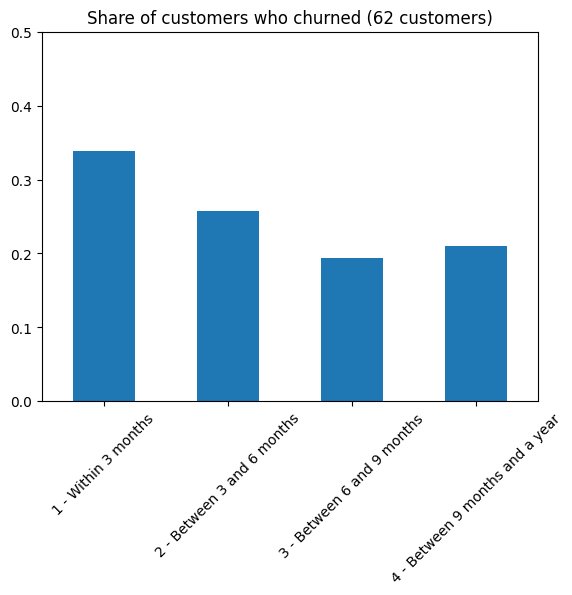

In [ ]:
# Create a bar plot
ax = business_pdf["months_before_churn_recod"].value_counts(normalize=True).sort_index().plot(kind='bar')

# Set the maximum value of the y-axis
ax.set_ylim(top=0.5)  # Adjust the maximum value as needed

# Pivot x labels by 45 degrees
plt.xticks(rotation=45)
plt.title("Share of customers who churned (62 customers)")
ax.set_xlabel('')

plt.show()

In [ ]:
payed_amount_ts = billing_pdf[["date", "payed_amount"]].set_index("date").resample("M").sum()
payed_amount_ts

,payed_amount
date,
2023-09-30,850176.14
2023-10-31,8623692.98
2023-11-30,8326973.42
2023-12-31,9077230.38
2024-01-31,8131434.86
2024-02-29,7171129.50
2024-03-31,5274279.64


In [ ]:
invoiced_amount_ts = billing_pdf[["date", "invoiced_amount"]].set_index("date").resample("M").sum()
invoiced_amount_ts

,invoiced_amount
date,
2023-09-30,5605063.95
2023-10-31,17201818.12
2023-11-30,16611778.42
2023-12-31,18348070.60
2024-01-31,16551206.01
2024-02-29,14638318.53
2024-03-31,10043744.58


In [ ]:
joined_pdf = invoiced_amount_ts.join(payed_amount_ts)
joined_pdf["discrepancy"] = joined_pdf["invoiced_amount"] - joined_pdf["payed_amount"]
joined_pdf["payement_collection_rate"] = joined_pdf["payed_amount"] / joined_pdf["invoiced_amount"]
joined_pdf

,invoiced_amount,payed_amount,discrepancy,payement_collection_rate
date,,,,
2023-09-30,5605063.95,850176.14,4754887.81,0.151680
2023-10-31,17201818.12,8623692.98,8578125.14,0.501325
2023-11-30,16611778.42,8326973.42,8284805.00,0.501269
2023-12-31,18348070.60,9077230.38,9270840.22,0.494724
2024-01-31,16551206.01,8131434.86,8419771.15,0.491290
2024-02-29,14638318.53,7171129.50,7467189.03,0.489888
2024-03-31,10043744.58,5274279.64,4769464.94,0.525131


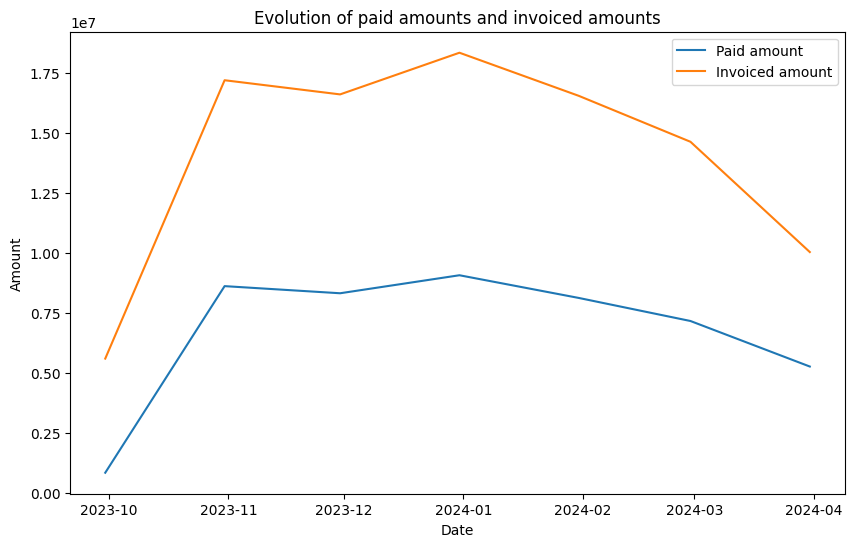

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(payed_amount_ts.index, payed_amount_ts['payed_amount'], label='Paid amount')
plt.plot(invoiced_amount_ts.index, invoiced_amount_ts['invoiced_amount'], label='Invoiced amount')

# Add titles and labels
plt.title('Evolution of paid amounts and invoiced amounts')
plt.xlabel('Date')
plt.ylabel('Amount')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
subscription_pdf["churn_count"].sum() / subscription_pdf["subscription_count"].sum()

0.010907403109770248